# Imports

In [1]:
from utils import *
from paths_and_parameters import *
first_n_peaks = 5

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    if isdir(path_figures):
        rmtree(path_figures)
    if isdir(path_results):
        rmtree(path_results)
    if isdir(path_database_exp):
        rmtree(path_database_exp)

#### Check if output folders exist. If not, create them.

In [3]:
if not isdir(path_figures):
    makedirs(path_figures)
if not isdir(path_results):
    makedirs(path_results)
if not isdir(path_database_exp):
    makedirs(path_database_exp)

# Read XRD Data and Database
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [4]:
%matplotlib inline
rcParams['font.size'] = 12

try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)
    
print(f'Shape of data: {data.shape}')
print('Initial calibration:')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

database = DatabaseXRD().read_cifs(path_database)
print('\nPhases in database:', len(database))

Loading: ../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/xrd.h5
Shape of data: (95, 170, 1280)
Initial calibration:
a = -1214.7, s = 1952.7, beta = 51.663
Theta range [19.77907407899562, 53.578190550653794]

Phases in database: 366


### Correct burnt pixels
Substitute burnt pixel with the average of the non burnt ones.

In [5]:
qtl = 0.999

data_max = (data.data - data.background).max(axis = 2)
indices_to_correct = data_max > quantile(data_max, qtl)

data.data[indices_to_correct] = data.data[~indices_to_correct].mean(axis = 0, keepdims = True)
data.background[indices_to_correct] = data.background[~indices_to_correct].mean(axis = 0, keepdims = True)
data.intensity[indices_to_correct] = data.intensity[~indices_to_correct].mean(axis = 0, keepdims = True)
data.signal_background_ratio[indices_to_correct] = data.signal_background_ratio[~indices_to_correct].mean(axis = 0, keepdims = True)
data.rescaling[indices_to_correct] = data.rescaling[~indices_to_correct].mean(axis = 0, keepdims = True)

print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} were corrected.')

17 pixels out of 16150 were corrected.


# Read XRF maps

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [10]:
data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf)
data_xrf.labels = flip(data_xrf.labels, axis = xrf_axes_flip)
y_x_ratio = data_xrf.labels.shape[0] / data_xrf.labels.shape[1]
print(f'Found {data_xrf.labels.shape[2]} images')

Found 24 images


### Correct burnt pixels and wrong scale in each XRF map; also calculate normalized XRF maps
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [11]:
qtl = 0.999
#qtl = 1

qtl_calculated = quantile(data_xrf.labels, qtl, axis = (0, 1))[newaxis, newaxis, :]
n_corrected = (data_xrf.labels > qtl_calculated).sum() / data_xrf.labels.shape[-1]
data_xrf.labels = clip(data_xrf.labels, None, qtl_calculated)
print(f'{n_corrected:.0f} pixels out of {data_xrf.labels.shape[0] * data_xrf.labels.shape[1]} were corrected on average in each XRF map.')

data_xrf.labels -= data_xrf.labels.min(axis = (0, 1), keepdims = True)

maps_xrf_norm = data_xrf.labels / nanmax(nanmax(data_xrf.labels, axis = 0, keepdims = True), axis = 1, keepdims = True)

17 pixels out of 16150 were corrected on average in each XRF map.


# Select primary phases

### Manually select them

In [8]:
hydrocerussite = database['Hydrocerussite'][0]
lazurite = database['Lazurite'][0]
cinnabar = database['Cinnabar'][1]

phases_primary = [hydrocerussite, lazurite, cinnabar]

### Take them from file `phases_selection_primary.dat`

In [9]:
phases_primary = phases_from_file('phases_selection_primary.dat', database)

Loaded phases: Fe2 O3 1, Goethite 10, Hematite 9, Siderite 1


# Search for primary phases

### Change initial calibration

In [9]:
#data.opt = array([-1208.08149362, 1948.24846333, 51.66346438])

### Create data structure

In [10]:
gm = GammaMap().from_data(data, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

### Autocalibration and search
Optimizes on $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [11]:
%%time
gm = gm.search()
L1loss, MSEloss, overlap_area = gm.metrics()

Using 8 CPUs
Using 8 CPUs
CPU times: user 11.7 s, sys: 1.92 s, total: 13.6 s
Wall time: 16.9 s


#### Fast mapping

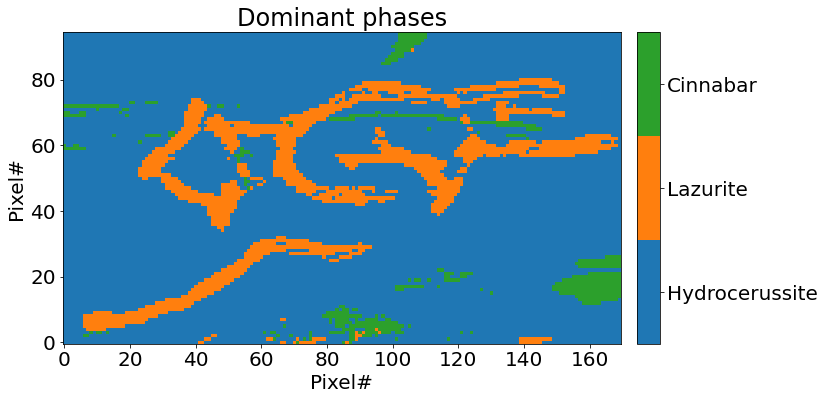

In [13]:
%matplotlib inline
rcParams['font.size'] = 20

fig, ax = subplots(figsize = (10, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(gm.phases) + 0.5, 1), len(gm.phases))
im = imshow(gm.selected(), interpolation = 'none', cmap = cmap_chosen, norm = norm_chosen)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(gm.phases)))
cbar.set_ticklabels([p.label for p in gm.phases])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

savefig(path_figures + 'fast_map_dominant_phases.png', bbox_inches = 'tight', dpi = 200)
show()

# Experimental phases

### Create experimental phases from a selected pixel for each primary phase, based on `criterion`

In [15]:
correction = data.rescaling**0.5
criterion = overlap_area * correction
experimental_phases = gm.select_phases(criterion, -5)

### Show each phase from its selected pixel

,Phase name,Pixel of choice,Presence in the pixel,Calibration in the pixel
0,Hydrocerussite,"(18, 21)",0.987,"-1200.8, 1940.1, 51.7"
1,Lazurite,"(39, 72)",0.982,"-1209.7, 1940.9, 51.7"
2,Cinnabar,"(106, 94)",0.972,"-1207.9, 1945.1, 51.7"


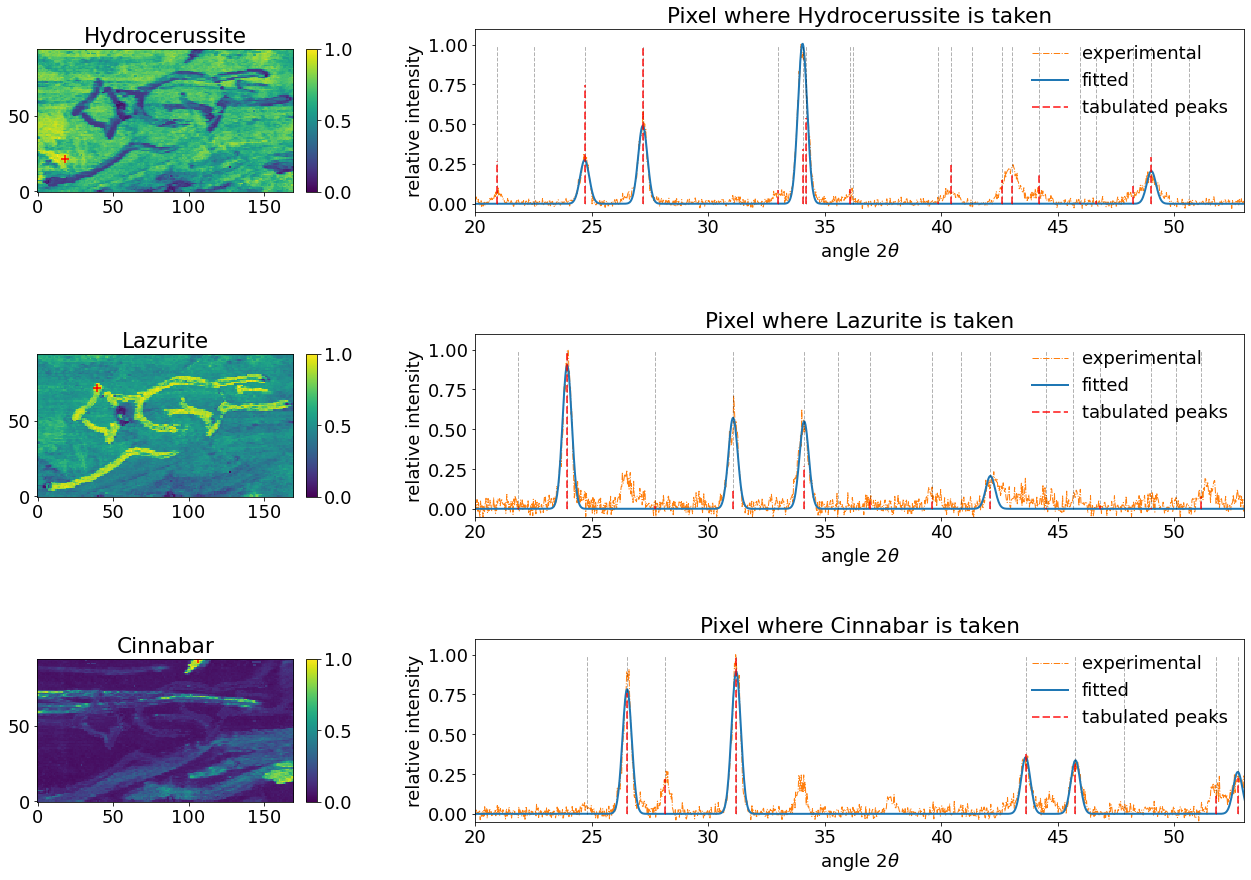

In [16]:
rcParams['font.size'] = 18

value_max = nanmax(nanmax(criterion, axis = 0, keepdims = True), axis = 1, keepdims = True)
matrix_plot = criterion / value_max

fig, axs = subplots(len(gm.phases), 2, figsize = (18, 4*len(gm.phases)),
                   gridspec_kw = {'width_ratios': [1, 3]})
fig.tight_layout(h_pad = 5, w_pad = 7)
df_phase_pixel = DataFrame(columns = ['Phase name', 'Pixel of choice', 'Presence in the pixel', 'Calibration in the pixel'])

for i, phase in enumerate(experimental_phases):

    if type(phase) == Phase:
        point = phase['point']
    else:
        point = phase[0]['point']
    x, y = gm.get_x_y(point)
    g = gm[point][i]

    if (len(experimental_phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    sca(ax)
    im = imshow(matrix_plot[..., i], interpolation = 'none', vmin = 0)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    #cbar.set_label('overlap')
    scatter(x, y, s = 50, c = 'red', marker = '+')
    ax.set_title(phase.label)

    if (len(experimental_phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    sca(ax)
    df_phase_pixel.loc[len(df_phase_pixel)] = [g.label, (x, y), matrix_plot[y, x, i], ', '.join([f'{g.opt[i]:.1f}' for i in range(3)])]
    g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
    g.plot(c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
    g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
    g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'Pixel where {phase.label} is taken')
    ax.legend(frameon=False)

    spectrum_to_save = array((g.spectrum.counts, g.spectrum.intensity)).T
    savetxt(f'{path_results}Point ({x}, {y}) - selection for {phase.label} - raw counts and intensity.dat', spectrum_to_save, fmt = ['%d', '%.4f'])

display(df_phase_pixel.style.format({'Presence in the pixel': '{:.3f}'}))
savefig(f'{path_figures}pixel selection for each phase.png', bbox_inches = 'tight', dpi = 300)
show()

### Select the phase and correct the point where it is taken

In [19]:
idx_phase = 0
print(f'Selected {experimental_phases[idx_phase].label} among {len(experimental_phases)} phases.')

Selected Hydrocerussite among 3 phases.


In [23]:
correct_point(experimental_phases, idx_phase, gm, 10, 10)
#correct_point(experimental_phases, 5, gm, 10, 34)

# Save .cif files

In [20]:
for phase in experimental_phases:
    filename = path_database_exp + phase.label + '.cif'
    print(filename)
    phase.save_cif(filename)

databaseEXP/MunchMuseum/M491/Profilo/Hydrocerussite.cif
databaseEXP/MunchMuseum/M491/Profilo/Lazurite.cif
databaseEXP/MunchMuseum/M491/Profilo/Cinnabar.cif


# Explore one pixel with decomposition of experimental phases

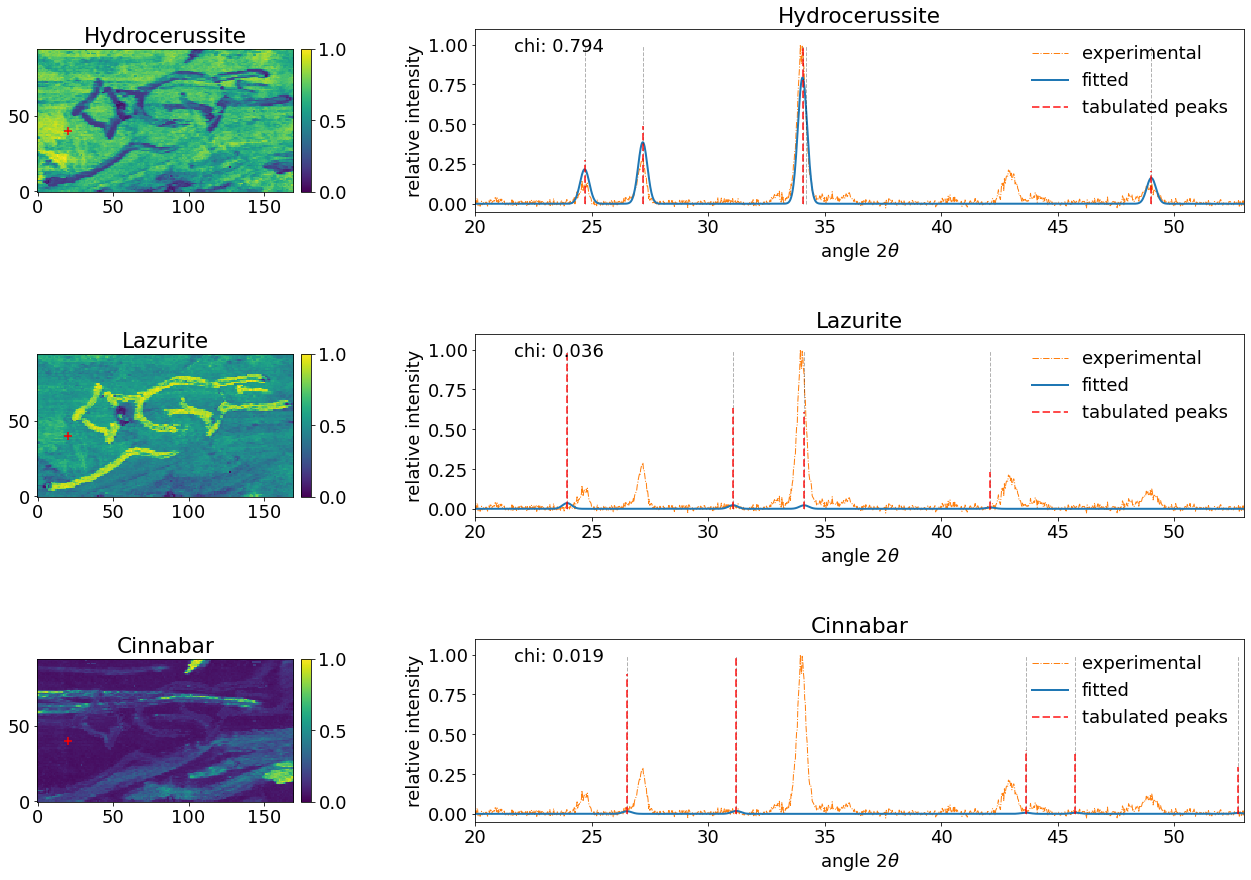

In [22]:
rcParams['font.size'] = 18
x, y = 20, 40

cs = ChiSearch(experimental_phases, gm.get_pixel(x, y).spectrum, sigma = sigma, min_theta = min_theta,
    max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
cs.fit_cycle(steps = 8, chi = True)

value_max = nanmax(nanmax(criterion, axis = 0, keepdims = True), axis = 1, keepdims = True)
matrix_plot = criterion / value_max

fig, axs = subplots(len(cs), 2, figsize = (18, 4*len(cs)),
                   gridspec_kw = {'width_ratios': [1, 3]})
fig.tight_layout(h_pad = 5, w_pad = 7)

for i, g in enumerate(cs):
    if (len(cs) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    sca(ax)
    im = imshow(matrix_plot[..., i], interpolation = 'none', vmin = 0)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
    scatter(x, y, s = 50, c = 'red', marker = '+')
    ax.set_title(g.label)

    if (len(cs) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    sca(ax)
    g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
    plot(cs[0].theta, cs.z_decomposed()[:, i], c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
    g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
    g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks')
    ax.annotate(f'chi: {cs.chi[0, i]:.3f}', xy = (0.05, 0.95),
        xycoords = 'axes fraction', horizontalalignment = 'left', verticalalignment = 'top')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(g.label)
    legend(frameon=False)

show()

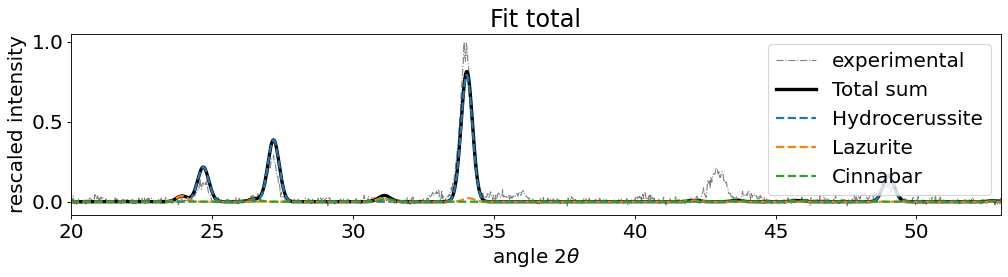

In [23]:
rcParams['font.size'] = 18

fig, ax = subplots(figsize = (15, 3))
sca(ax)
cs[0].plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
plot(cs[0].theta, cs.z(), c = 'black', ls = '-', lw = 3, label = 'Total sum')
for i_phase in range(len(cs)):
    plot(cs[0].theta, cs.z_decomposed()[:, i_phase],
         ls = '--', lw = 2, label = cs[i_phase].label)
ax.set_xlim(min_theta, max_theta)
ax.legend(loc = 'upper right')
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('rescaled intensity')
ax.set_title('Fit total')
fig.set_dpi(80)
show()

# Select secondary phases

### Manually select them

In [24]:
bone_black = database['Bone_Black'][0]
goethite = database['Goethite'][0]
hematite = database['Hematite'][4]
yellow_cd_zn_s = database['Cadmium zinc sulphide yellow'][0]

phases_secondary = [bone_black, goethite, hematite, yellow_cd_zn_s]

### Take them from file `phases_selection_secondary.dat`

In [25]:
phases_secondary = phases_from_file('phases_selection_secondary.dat', database)

Loaded phases: Jarosite 15, Pyrite 4


# Search for secondary phases

### Smooth data

In [26]:
step = 2
method = 'mean'
#method = 'max'

data_smooth = data.generate_smooth(step, method)

Generating smooth data...
Removing background...
Done.
Done.


### Check rescaling factor

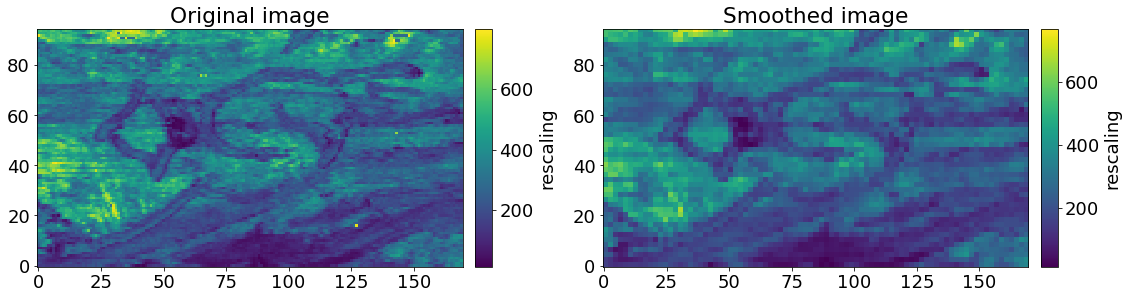

In [27]:
rcParams['font.size'] = 18

fig, axs = subplots(1, 2, figsize = (15, 6))
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(data.rescaling.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_label('rescaling')
ax.set_title('Original image')

ax = axs[1]
im = ax.imshow(data_smooth.rescaling.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_label('rescaling')
ax.set_title('Smoothed image')

show()

### Refit primary phases on smoothed data

In [28]:
%%time
gm1 = GammaMap().from_data(data_smooth, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

gm1 = gm1.search()

overlap_area_1 = gm1.overlap_area()

Using 8 CPUs
CPU times: user 13 s, sys: 1.82 s, total: 14.8 s
Wall time: 17.1 s


### Fit secondary phases on smoothed data

In [29]:
%%time

#phases_secondary = [bone_black, goethite, hematite]

gm2 = GammaMap_Secondary().from_data(gm1, data_smooth, phases_secondary, sigma = sigma, min_theta = min_theta,
    max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)

gm2 = gm2.fit_cycle(steps = 6, gamma = True)

overlap_area_compare_2 = gm2.overlap_area_difference()

Using 8 CPUs
CPU times: user 16 s, sys: 6.26 s, total: 22.3 s
Wall time: 23.5 s


# Secondary experimental phases

### Create experimental phases from a selected pixel for each secondary phase, based on `criterion_2`

In [31]:
correction = data_smooth.rescaling**0.5
criterion_1 = overlap_area_1 * correction
criterion_2 = overlap_area_compare_2 * correction

experimental_phases_2 = gm2.select_phases(criterion_2, -5)

### Show each secondary phase from its selected pixel

Jarosite 15 (120, 2) 460 [-1206.12414381  1954.00649847    51.66346438]
Pyrite 4 (55, 49) 8385 [-1196.43479488  1930.31484077    51.66346438]


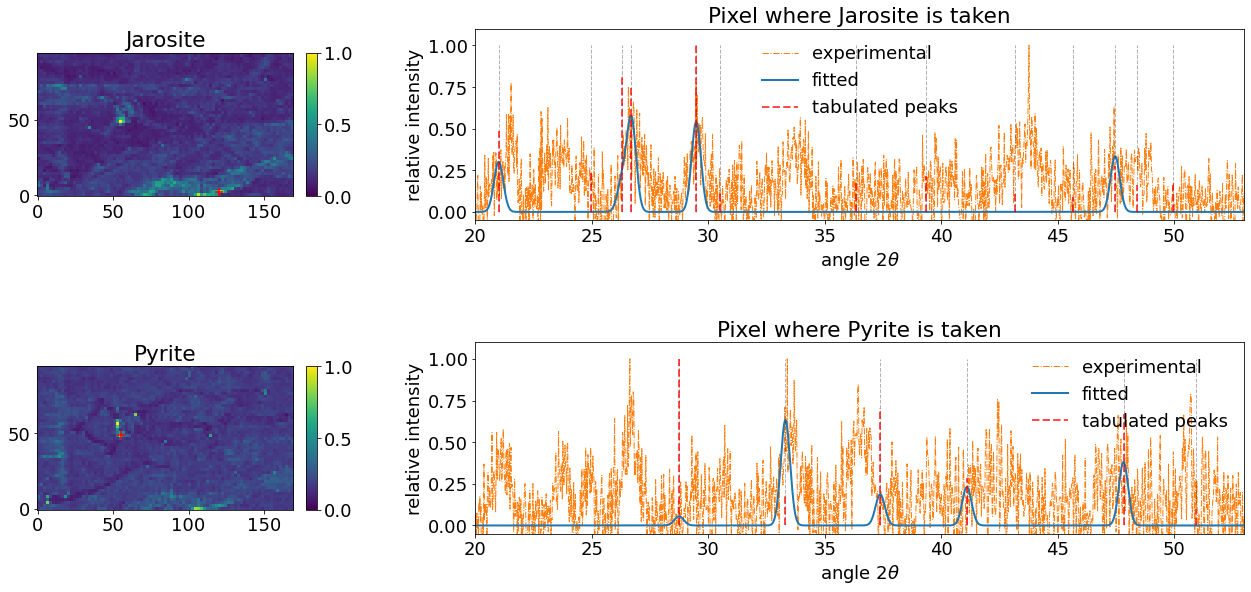

In [32]:
rcParams['font.size'] = 18

value_max = nanmax(nanmax(criterion_2, axis = 0, keepdims = True), axis = 1, keepdims = True)
matrix_plot = criterion_2 / value_max

fig, axs = subplots(len(gm2.phases), 2, figsize = (18, 4*len(gm2.phases)),
                   gridspec_kw = {'width_ratios': [1, 3]})
fig.tight_layout(h_pad = 5, w_pad = 7)

for i, phase in enumerate(experimental_phases_2):

    if type(phase) == Phase:
        point = phase['point']
    else:
        point = phase[0]['point']
    x, y = gm.get_x_y(point)
    g = gm2[point][i]

    if (len(experimental_phases_2) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    sca(ax)
    im = imshow(matrix_plot[..., i], interpolation = 'none', vmin = 0)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    #cbar.set_label('overlap')
    scatter(x, y, s = 50, c = 'red', marker = '+')
    ax.set_title(phase.label)

    if (len(experimental_phases_2) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    sca(ax)
    #g.fit_cycle(gamma = True, steps = 128,a=True,s=True)
    print(g.label, (x, y), point, g.opt)
    g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
    g.plot(c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
    g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
    g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'Pixel where {phase.label} is taken')
    ax.legend(frameon=False)

    spectrum_to_save = array((g.spectrum.counts, g.spectrum.intensity)).T
    savetxt(f'{path_results}Point ({x}, {y}) - selection for {phase.label} - raw counts and intensity.dat', spectrum_to_save, fmt = ['%d', '%.4f'])

savefig(f'{path_figures}pixel selection for each phase.png', bbox_inches = 'tight', dpi = 300)
show()

### Select the phase and correct the point where it is taken

In [33]:
idx_phase = 0
print(f'Selected {experimental_phases_2[idx_phase].label} among {len(experimental_phases_2)} phases.')

Selected Jarosite among 2 phases.


In [48]:
correct_point(experimental_phases_2, idx_phase, gm2, 10, 20)

# Save .cif files

In [34]:
for phase in experimental_phases_2:
    filename = path_database_exp + phase.label + '.cif'
    print(filename)
    phase.save_cif(filename)

databaseEXP/MunchMuseum/M491/Profilo/Jarosite.cif
databaseEXP/MunchMuseum/M491/Profilo/Pyrite.cif


# Explore one pixel with decomposition of experimental phases

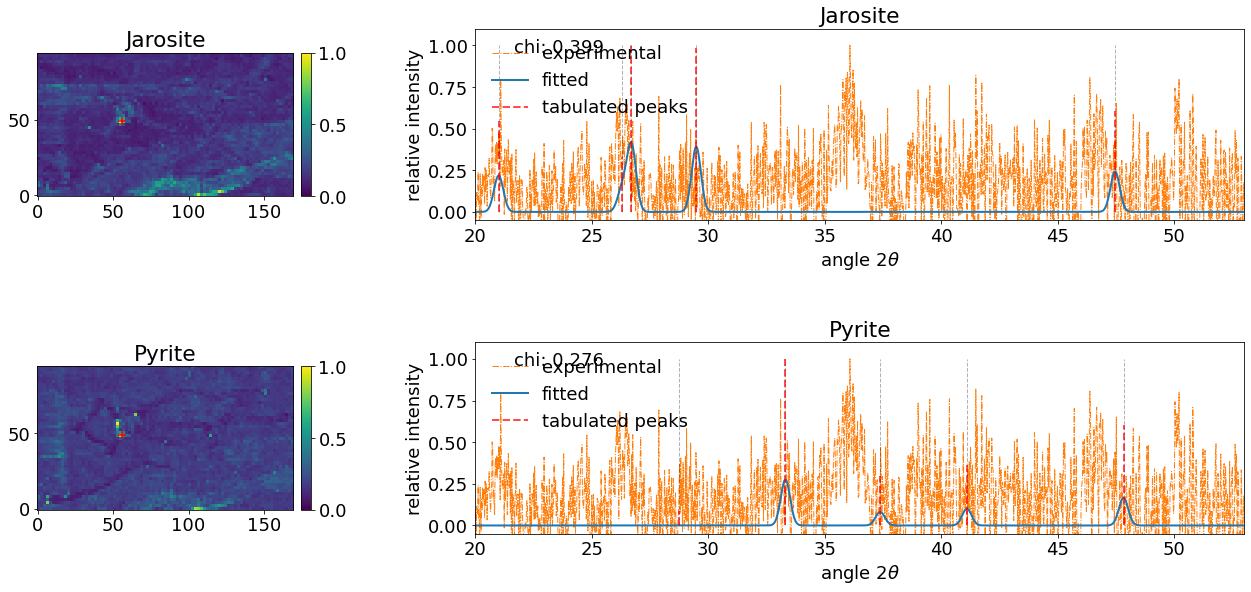

In [42]:
rcParams['font.size'] = 18
x, y = 56, 49

cs = ChiSearch(experimental_phases_2, gm2.get_pixel(x, y).spectrum, sigma = sigma, min_theta = min_theta,
    max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
cs.fit_cycle(steps = 8, chi = True)

value_max = nanmax(nanmax(criterion_2, axis = 0, keepdims = True), axis = 1, keepdims = True)
matrix_plot = criterion_2 / value_max

fig, axs = subplots(len(cs), 2, figsize = (18, 4*len(cs)),
                   gridspec_kw = {'width_ratios': [1, 3]})
fig.tight_layout(h_pad = 5, w_pad = 7)

for i, g in enumerate(cs):
    if (len(cs) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    sca(ax)
    im = imshow(matrix_plot[..., i], interpolation = 'none', vmin = 0)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
    scatter(x, y, s = 50, c = 'red', marker = '+')
    ax.set_title(g.label)

    if (len(cs) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    sca(ax)
    g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
    plot(cs[0].theta, cs.z_decomposed()[:, i], c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
    g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
    g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks')
    ax.annotate(f'chi: {cs.chi[0, i]:.3f}', xy = (0.05, 0.95),
        xycoords = 'axes fraction', horizontalalignment = 'left', verticalalignment = 'top')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(g.label)
    legend(frameon=False)

show()

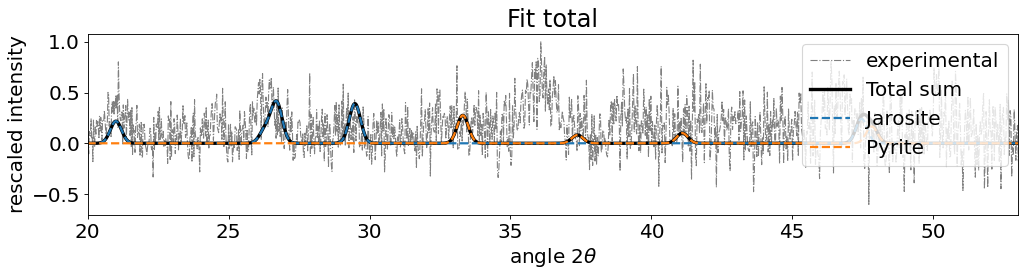

In [43]:
rcParams['font.size'] = 18

fig, ax = subplots(figsize = (15, 3))
sca(ax)
cs[0].plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
plot(cs[0].theta, cs.z(), c = 'black', ls = '-', lw = 3, label = 'Total sum')
for i_phase in range(len(cs)):
    plot(cs[0].theta, cs.z_decomposed()[:, i_phase],
         ls = '--', lw = 2, label = cs[i_phase].label)
ax.set_xlim(min_theta, max_theta)
ax.legend(loc = 'upper right')
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('rescaled intensity')
ax.set_title('Fit total')
fig.set_dpi(80)
show()